In [1]:
import torch
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm 
import numpy as np
import pandas as pd 
from glob import glob
import random
import json

In [2]:
df = pd.read_csv("/data/healthy-ml/scratch/qixuanj/generative_validation/ALIA/data/iwildcam_v2.0/train_extra_subset.csv")

In [11]:
with open("/mnt/scratch-lids/scratch/qixuanj/iwildcam/iwildcam2020_train_annotations.json", "r") as f: 
    train_data = json.load(f)

In [13]:
with open("/mnt/scratch-lids/scratch/qixuanj/iwildcam/iwildcam2020_test_information.json", "r") as f: 
    test_data = json.load(f)

In [15]:
train_data.keys()

dict_keys(['annotations', 'images', 'categories', 'info'])

In [17]:
train_data['annotations'][0]

{'count': 1,
 'image_id': '96b00332-21bc-11ea-a13a-137349068a90',
 'id': 'a292dd3c-21bc-11ea-a13a-137349068a90',
 'category_id': 73}

In [18]:
train_data['images'][0]

{'seq_num_frames': 1,
 'location': 267,
 'datetime': '2013-08-08 11:45:00.000',
 'id': '96b00332-21bc-11ea-a13a-137349068a90',
 'frame_num': 1,
 'seq_id': '96b004ea-21bc-11ea-a13a-137349068a90',
 'width': 1795,
 'height': 1222,
 'file_name': '96b00332-21bc-11ea-a13a-137349068a90.jpg'}

In [19]:
train_data['categories'][0]

{'count': 78981, 'id': 0, 'name': 'empty'}

In [22]:
test_data.keys()

dict_keys(['images', 'categories', 'info'])

In [23]:
test_data['images'][0]

{'seq_num_frames': 1,
 'location': 84,
 'datetime': '2013-08-02 21:44:00.000',
 'id': '88037cce-21bc-11ea-a13a-137349068a90',
 'frame_num': 1,
 'seq_id': '88037e90-21bc-11ea-a13a-137349068a90',
 'width': 2771,
 'height': 1779,
 'file_name': '88037cce-21bc-11ea-a13a-137349068a90.jpg'}

In [42]:
# seq_id is not unique, file_name is 
all_train_seq_ids = []
for i in range(len(train_data['images'])): 
    all_train_seq_ids.append(train_data['images'][i]['file_name'])

In [43]:
print(len(all_train_seq_ids))
all_train_seq_ids = np.unique(np.array(all_train_seq_ids))
print(len(all_train_seq_ids))

217959
217959


In [46]:
all_train_seq_ids = [x.split('.')[0] for x in all_train_seq_ids]

In [51]:
# Check if subset is in downloaded dataset -> yes to all 
files = ["train_subset.csv", "train_extra_subset.csv", "val_subset.csv", "test_subset.csv",]
for file in files:
    df = pd.read_csv(f"/data/healthy-ml/scratch/qixuanj/generative_validation/ALIA/data/iwildcam_v2.0/{file}")
    shared = np.intersect1d(df['image_id'].values, np.array(all_train_seq_ids))
    print(file)
    print(len(df['image_id'].unique()))
    print(len(shared))

train_subset.csv
6052
6052
train_extra_subset.csv
2224
2224
val_subset.csv
2826
2826
test_subset.csv
8483
8483


In [2]:
from wilds.common.metrics.all_metrics import Accuracy, Recall, F1

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from collections import Counter
import wilds

In [4]:
def get_counts(labels):
    values, counts = np.unique(labels, return_counts=True)
    sorted_tuples = zip(*sorted(zip(values, counts))) # this just ensures we are getting the counts in the sorted order of the keys
    values, counts = [ list(tuple) for tuple in  sorted_tuples]
    fracs   = 1 / torch.Tensor(counts)
    return fracs / torch.max(fracs)

class Wilds:
    """
    Wrapper for the WILDS dataset.
    """
    def __init__(self, root="/work/datasets", split='train', transform=None):
        self.dataset = wilds.get_dataset(dataset="iwildcam", root_dir=root)#, download=True)
        self.split_dataset = self.dataset.get_subset(split, transform=transform)
        self._metadata_fields = self.split_dataset.metadata_fields
        self.classes = list(range(self.split_dataset.n_classes))
        self.df = pd.DataFrame(self.split_dataset.metadata_array.numpy(), columns=self.split_dataset.metadata_fields)
        self.groups = self.df.location.values
        self.labels = self.targets = self.df.y.values
        self.class_weights = get_counts(self.labels)
        self.samples = [(i, l) for (i, l) in zip(self.df.sequence.values, self.labels)]
        # self.locations = [m[0] for m in self.split_dataset._metadata_array]
        # location = LOCATION_MAP_INV[1] if split == 'test' else LOCATION_MAP_INV[0]
        # self.location_idxs = np.where(np.array(self.locations) == location)[0]
        # self.groups = [location for _ in range(len(self.location_idxs))]

    def __len__(self):
        return len(self.split_dataset)

    def __getitem__(self, idx):
        # map the idx to the location idx (filter out all other locations)
        # idx = self.location_idxs[idx]
        img, label, metadata = self.split_dataset[idx]
        return img, label, self.groups[idx]

class WILDS:
    """
    Specific subset of WILDS containing 6 classes and 2 test locations.
    """
    def __init__(self, root='/mnt/scratch-lids/scratch/qixuanj/iwildcam/train', split='train', transform=None):
        self.root = root
        self.df = pd.read_csv(f'/data/healthy-ml/scratch/qixuanj/generative_validation/ALIA/data/iwildcam_v2.0/{split}_subset.csv')
        self.transform = transform
        self.class_names = sorted(self.df.y.unique())
        self.label_map = {j:i for i, j in enumerate(self.class_names)}
        self.labels = [self.label_map[i] for i in self.df.y]
        self.samples = [(os.path.join(root, i), l) for (i, l) in zip(self.df.filename, self.labels)]
        self.targets = [l for _, l in self.samples]
        self.classes = list(sorted(self.df.y.unique()))
        self.locations = self.df.location_remapped.unique()
        self.location_map = {j:i for i, j in enumerate(self.locations)}
        self.location_labels = [self.location_map[i] for i in self.df.location_remapped]
        self.groups = self.location_labels
        self.class_weights = get_counts(self.labels)
        self.group_names = self.locations
        self.class_names = ['background', 'cattle', 'elephants', 'impalas', 'zebras', 'giraffes', 'dik-diks']
        print(f"Num samples per class {Counter(self.labels)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        location = self.location_labels[idx]
        return img, label, location

    def inspect_location(self, location):
        assert location in self.locations
        location_df = self.df[self.df.location_remapped == location]
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
        idx = np.random.choice(list(range(len(location_df))))
        location_df['y'].value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title(f'Location {location} (n={len(location_df)}) class counts')
        axs[1].imshow(Image.open(os.path.join(self.root, location_df.iloc[idx].filename)))
        axs[1].set_title(f'Location {location} (n={len(location_df)}) class {location_df.iloc[idx].y} (idx={idx})')
        axs[1].axis('off')
        plt.show()

    def inspect_class(self, class_idx):
        assert class_idx in self.classes
        class_df = self.df[self.df.y == class_idx]
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
        idx = np.random.choice(list(range(len(class_df))))
        class_df['location_remapped'].value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title(f'Class {class_idx} (n={len(class_df)}) location counts')
        axs[1].imshow(Image.open(os.path.join(self.root, class_df.iloc[idx].filename)))
        axs[1].set_title(f'Class {class_idx} (n={len(class_df)}) location {class_df.iloc[idx].location_remapped} (idx={idx}) ({class_df.iloc[idx].filename})')
        axs[1].axis('off')
        plt.show()

    @staticmethod
    def eval(y_pred, y_true, prediction_fn=None):
        """
        Computes all evaluation metrics.
        Args:
            - y_pred (Tensor): Predictions from a model. By default, they are predicted labels (LongTensor).
                               But they can also be other model outputs such that prediction_fn(y_pred)
                               are predicted labels.
            - y_true (LongTensor): Ground-truth labels
            - metadata (Tensor): Metadata
            - prediction_fn (function): A function that turns y_pred into predicted labels
        Output:
            - results (dictionary): Dictionary of evaluation metrics
            - results_str (str): String summarizing the evaluation metrics
        """
        metrics = [
            Accuracy(prediction_fn=prediction_fn),
            Recall(prediction_fn=prediction_fn, average='macro'),
            F1(prediction_fn=prediction_fn, average='macro'),
        ]

        results = {}

        for i in range(len(metrics)):
            results.update({
                **metrics[i].compute(y_pred, y_true),
                        })

        results_str = (
            f"Average acc: {results[metrics[0].agg_metric_field]:.3f}\n"
            f"Recall macro: {results[metrics[1].agg_metric_field]:.3f}\n"
            f"F1 macro: {results[metrics[2].agg_metric_field]:.3f}\n"
        )

        return results, results_str

In [5]:
train_ds = WILDS(split="train")
train_extra_ds = WILDS(split="train_extra")
val_ds = WILDS(split="val")
test_ds = WILDS(split="test")

Num samples per class Counter({0: 2210, 3: 981, 1: 801, 4: 720, 6: 514, 5: 460, 2: 366})
Num samples per class Counter({3: 625, 1: 506, 6: 468, 0: 402, 2: 91, 4: 85, 5: 47})
Num samples per class Counter({0: 2006, 6: 244, 1: 206, 3: 140, 4: 119, 5: 58, 2: 53})
Num samples per class Counter({3: 4533, 2: 2003, 1: 1416, 6: 213, 4: 144, 0: 127, 5: 47})


In [23]:
# Class 
# print(train_ds.label_map)
print(train_ds.class_names)
print("train")
print(np.unique(np.array(train_ds.labels), return_counts=True))
print("train extra")
print(np.unique(np.array(train_extra_ds.labels), return_counts=True))
print("val")
print(np.unique(np.array(val_ds.labels), return_counts=True))
print("test")
print(np.unique(np.array(test_ds.labels), return_counts=True))

['background', 'cattle', 'elephants', 'impalas', 'zebras', 'giraffes', 'dik-diks']
train
(array([0, 1, 2, 3, 4, 5, 6]), array([2210,  801,  366,  981,  720,  460,  514]))
train extra
(array([0, 1, 2, 3, 4, 5, 6]), array([402, 506,  91, 625,  85,  47, 468]))
val
(array([0, 1, 2, 3, 4, 5, 6]), array([2006,  206,   53,  140,  119,   58,  244]))
test
(array([0, 1, 2, 3, 4, 5, 6]), array([ 127, 1416, 2003, 4533,  144,   47,  213]))


In [20]:
# Unique id for locations, there are 15 locations
print(train_ds.group_names)
print(train_ds.location_map)
print(train_ds.locations)
print(len(train_ds.locations))
print(np.unique(np.array(train_ds.location_labels), return_counts=True))

[  1   5  47  52  90 121 135 138 140 142 201 215 233 304 322]
{1: 0, 5: 1, 47: 2, 52: 3, 90: 4, 121: 5, 135: 6, 138: 7, 140: 8, 142: 9, 201: 10, 215: 11, 233: 12, 304: 13, 322: 14}
[  1   5  47  52  90 121 135 138 140 142 201 215 233 304 322]
15
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([ 342, 1045,  226,  213,  276,  213,  342,  136,  321,  342,  123,
        173,  195, 2065,   40]))


In [25]:
# Location 
print("train")
print(train_ds.group_names)
print(np.unique(np.array(train_ds.location_labels), return_counts=True))
print("train extra")
print(train_extra_ds.group_names)
print(np.unique(np.array(train_extra_ds.location_labels), return_counts=True))
print("val")
print(val_ds.group_names)
print(np.unique(np.array(val_ds.location_labels), return_counts=True))
print("test")
print(test_ds.group_names)
print(np.unique(np.array(test_ds.location_labels), return_counts=True))

train
[  1   5  47  52  90 121 135 138 140 142 201 215 233 304 322]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([ 342, 1045,  226,  213,  276,  213,  342,  136,  321,  342,  123,
        173,  195, 2065,   40]))
train extra
[ 24  56  73  76  86 104 125 163 169 184 241 302 315]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([309, 151, 695,  18,  67,  51, 236, 261, 147, 126,  28,  33, 102]))
val
[  6   8  15  16  17  18  19  20  23  28  31  32  34  35  38  39  41  43
  44  45  46  47  51  52  60  61  67  70  75  77  83  85  87  88  89  90
  91  93  97  98  99 103 106 109 111 112 116 121 124 133 135 137 138 141
 144 147 149 150 157 158 162 165 172 174 177 181 182 185 189 190 192 194
 195 196 197 199 201 202 203 204 206 208 212 213 215 216 218 219 221 226
 228 232 235 238 242 244 251 252 256 257 258 264 266 271 272 274 276 277
 283 284 285 290 292 293 297 299 300 304 313 314 317 318]
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  

In [29]:
np.random.randint(0, len(test_ds), 5)

array([1032, 3922, 1561, 7529, 7871])

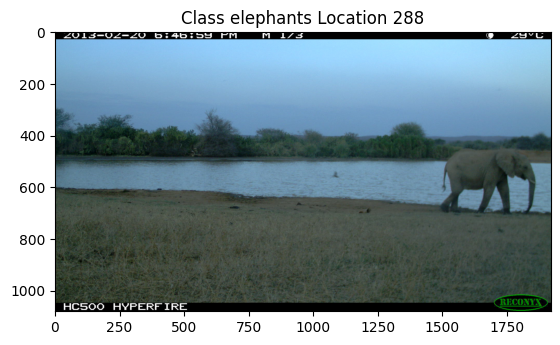

In [67]:
# Visualize images 
indices = np.random.randint(0, len(test_ds), 1)

for i in indices: 
    img, class_label, location_label = test_ds[i]
    
    plt.figure()
    plt.title(f"Class {test_ds.class_names[class_label]} Location {test_ds.group_names[location_label]}")
    plt.imshow(img)

In [68]:
stat = ImageStat.Stat(img)
print(stat.mean)
print(stat.extrema)
print(stat.rms)
print(stat.var)

[84.75484616126543, 110.86436390817902, 121.11817611882717]
[(0, 255), (0, 255), (0, 255)]
[95.62023989856975, 125.85819775382245, 144.29797316928568]
[1959.8463304402615, 3549.378757075132, 6152.292474412653]


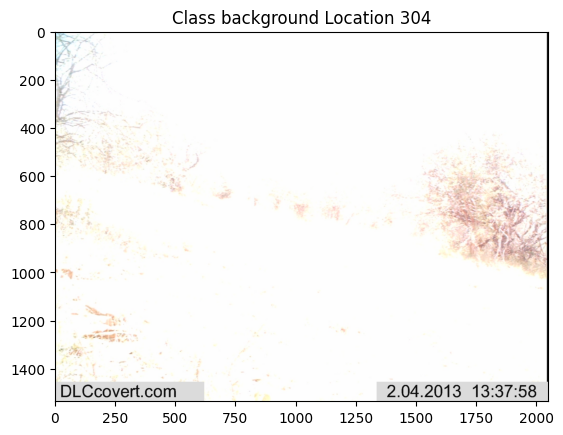

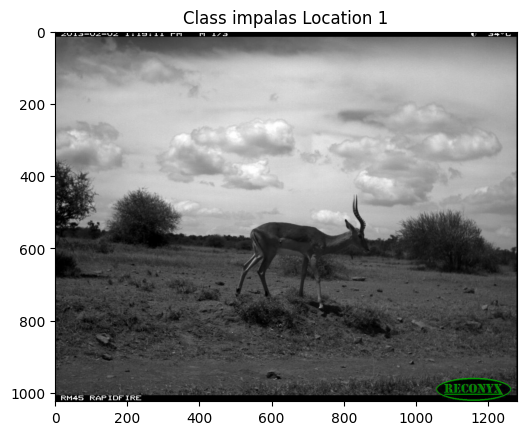

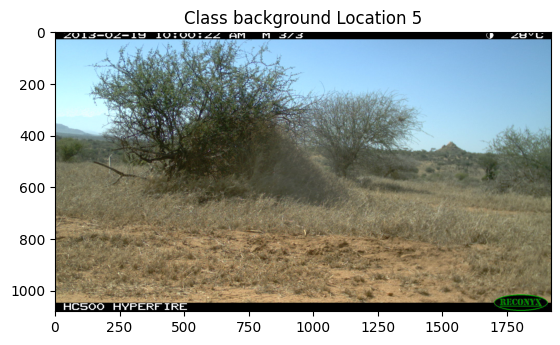

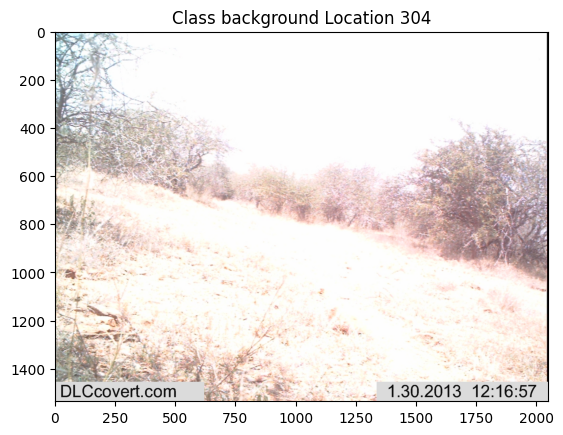

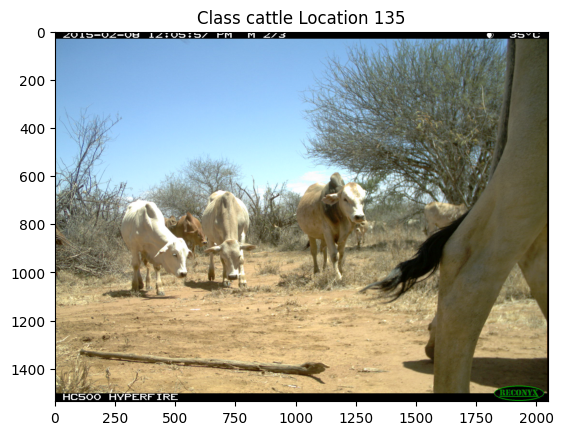

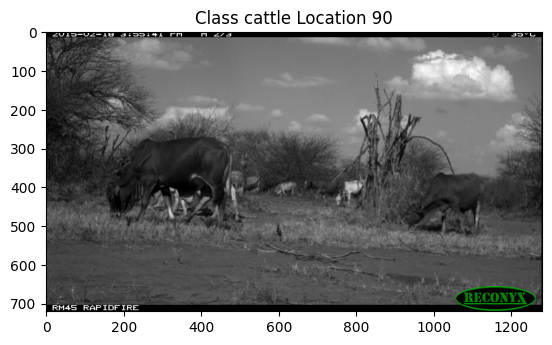

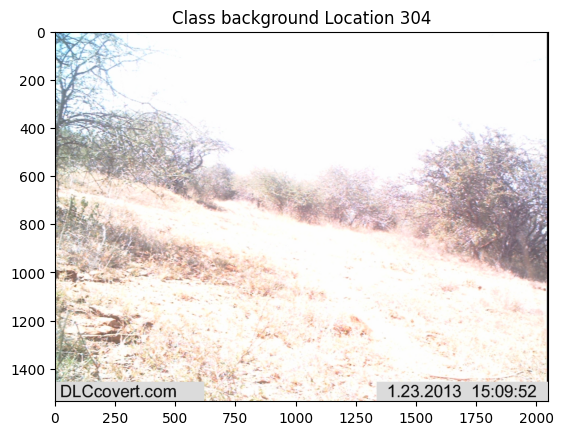

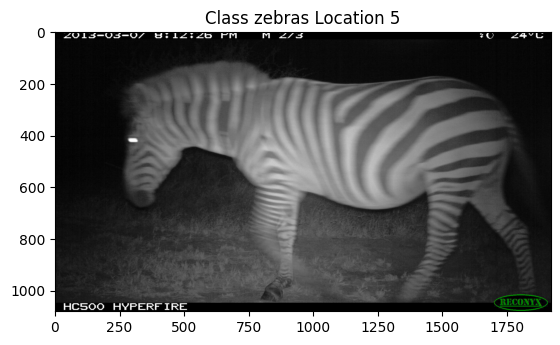

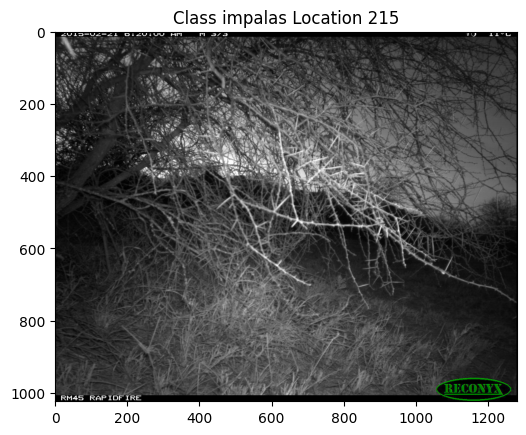

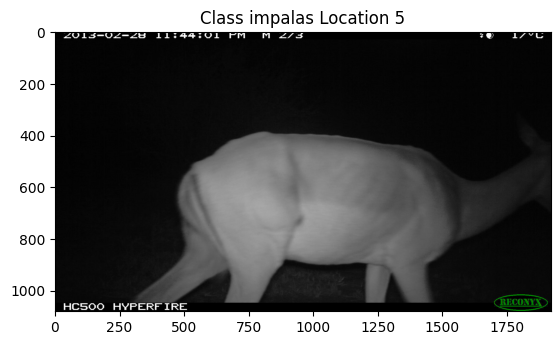

In [41]:
indices = np.random.randint(0, len(train_ds), 10)

for i in indices: 
    img, class_label, location_label = train_ds[i]
    
    plt.figure()
    plt.title(f"Class {train_ds.class_names[class_label]} Location {train_ds.group_names[location_label]}")
    plt.imshow(img)

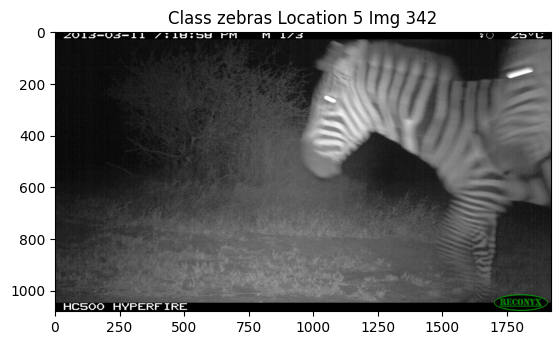

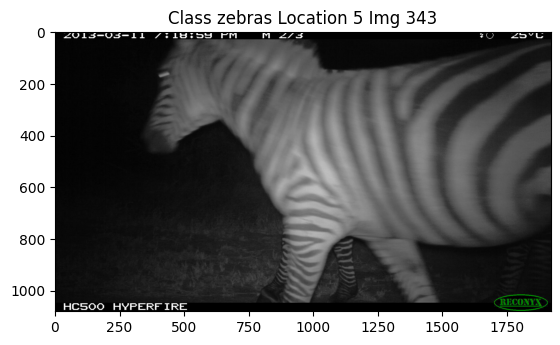

In [52]:
# Only print out image from specific camera trap 
count = 0
trap = 5

for i in range(len(train_ds)): 
    img, class_label, location_label = train_ds[i]
    location = train_ds.group_names[location_label]
    if location == trap:
        plt.figure()
        plt.title(f"Class {train_ds.class_names[class_label]} Location {location} Img {i}")
        plt.imshow(img)
        count += 1
        if count > 1: 
            break

In [58]:
from PIL import Image, ImageStat

In [66]:
stat = ImageStat.Stat(img)
print(stat.mean)
print(stat.extrema)
print(stat.rms)
print(stat.var)

[53.941425540123454, 54.210720486111114, 53.94209008487654]
[(0, 255), (0, 255), (0, 255)]
[72.29243965725063, 72.59058838039569, 72.29261854293807]
[2316.519442296539, 2330.59130578877, 2316.4736130698166]


## Setting 1: all color, different background locations

In [ ]:
'''
train: 
val: 
extra: 288 (with river)
test: 288 (with river)
'''

In [70]:
from tqdm import tqdm 
import pickle

In [ ]:
count = 0
trap = 288

img_stats = {}
for i in range(len(test_ds)): 
    img, class_label, location_label = test_ds[i]
    location = test_ds.group_names[location_label]
    if location == trap:
        stat = ImageStat.Stat(img)
        img_stats[i] = {}
        img_stats[i]['mean'] = stat.mean
        img_stats[i]['rms'] = stat.rms
with open(f"iwildcam_preprocess/img_stat_{trap}.pkl", "wb") as f: 
    pickle.dump(img_stats, f)